In [120]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from keras import layers

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.17.0
Keras version: 3.6.0


In [121]:
# Load the dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [122]:
# print the last 5 rows of the dataset
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [123]:
# Check for missing values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [124]:
# Drop rows with missing values
dataset.dropna(inplace=True)

In [125]:
# One-hot encode the 'Origin' column
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [126]:
# Split dataset into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

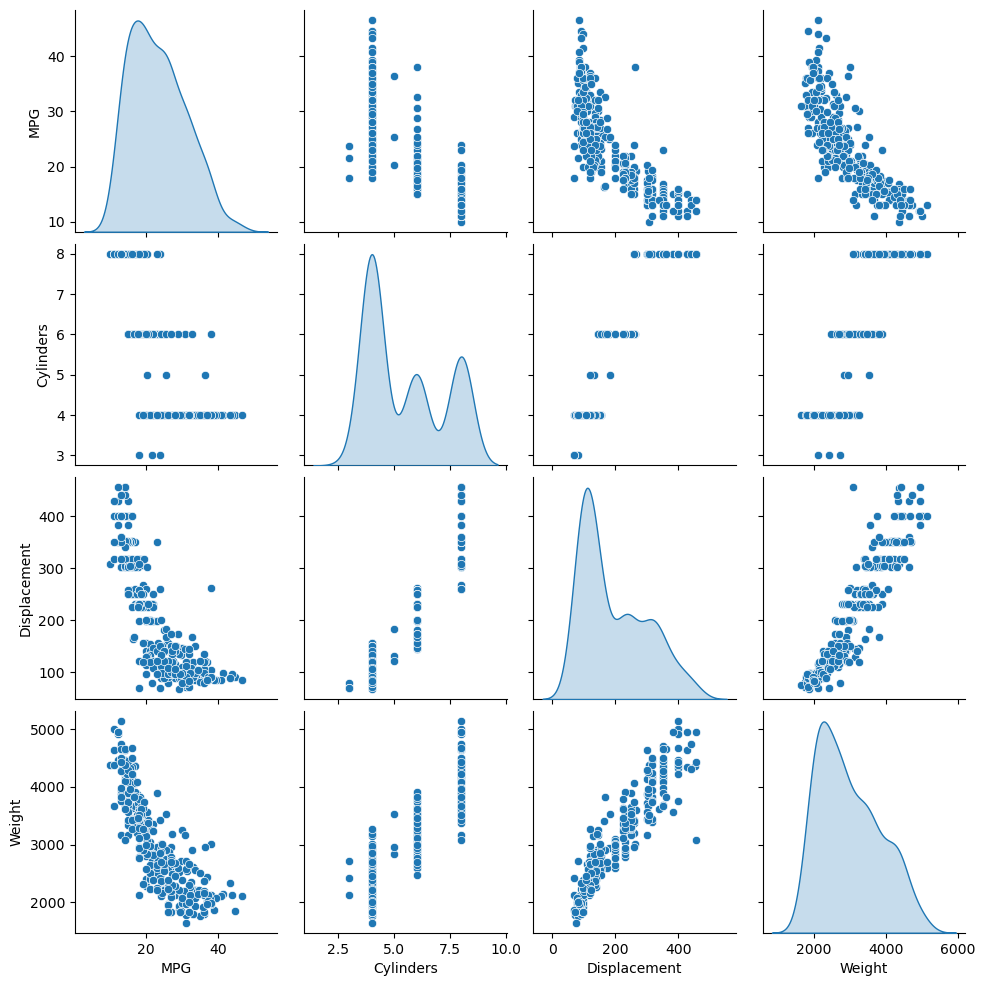

In [127]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [128]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


In [129]:
# Split the dataset into features and labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [130]:
# Regress MPG on Horsepower
horsepower = np.array(train_features['Horsepower'])

horsepower_model = keras.Sequential([
    layers.Dense(1, input_shape=(1,))
])

horsepower_model.summary()

/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [131]:
# Predicting Horsepower
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[-106.801],
       [-125.313],
       [-227.842],
       [ -89.713],
       [ -95.409],
       [-128.161],
       [ -85.441],
       [ -95.409],
       [-135.281],
       [-125.313]], dtype=float32)

In [132]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [133]:

history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=2,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
8/8 - 0s - 51ms/step - loss: 135.5665 - val_loss: 88.2650
Epoch 2/100
8/8 - 0s - 4ms/step - loss: 51.6455 - val_loss: 12.2350
Epoch 3/100
8/8 - 0s - 4ms/step - loss: 22.0871 - val_loss: 28.2095
Epoch 4/100
8/8 - 0s - 4ms/step - loss: 20.3602 - val_loss: 12.2327
Epoch 5/100
8/8 - 0s - 4ms/step - loss: 14.2371 - val_loss: 13.3778
Epoch 6/100
8/8 - 0s - 4ms/step - loss: 13.1875 - val_loss: 13.6336
Epoch 7/100
8/8 - 0s - 4ms/step - loss: 12.2475 - val_loss: 12.8132
Epoch 8/100
8/8 - 0s - 4ms/step - loss: 11.5977 - val_loss: 11.9556
Epoch 9/100
8/8 - 0s - 4ms/step - loss: 11.4088 - val_loss: 12.0234
Epoch 10/100
8/8 - 0s - 4ms/step - loss: 10.9897 - val_loss: 11.9748
Epoch 11/100
8/8 - 0s - 4ms/step - loss: 11.1058 - val_loss: 11.7379
Epoch 12/100
8/8 - 0s - 4ms/step - loss: 10.8923 - val_loss: 11.5813
Epoch 13/100
8/8 - 0s - 4ms/step - loss: 10.7110 - val_loss: 11.4791
Epoch 14/100
8/8 - 0s - 4ms/step - loss: 10.6226 - val_loss: 11.3773
Epoch 15/100
8/8 - 0s - 4ms/step - loss: 

In [134]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,5.346813,6.146759,95
96,5.454386,4.241468,96
97,5.031493,4.503820,97
98,4.471583,4.119956,98
99,4.182145,4.136830,99


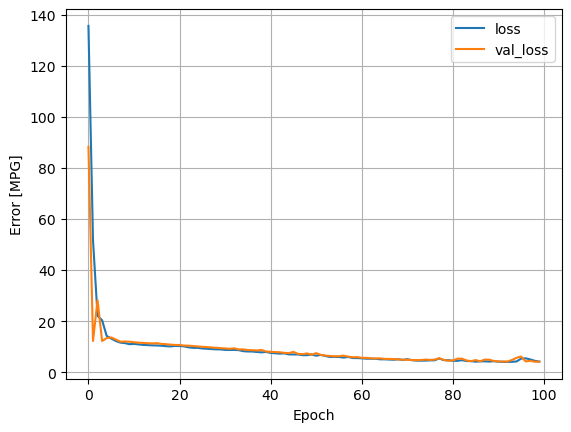

In [135]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


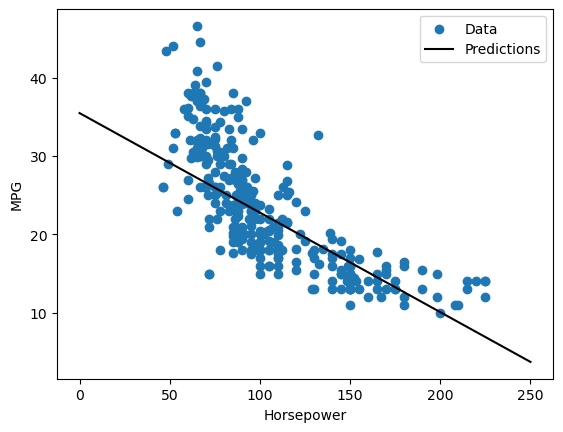

In [136]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

plot_horsepower(x, y)

In [137]:
# Regress MPG on all features
model = keras.Sequential([
    layers.Dense(1, input_shape=(train_features.shape[1],))
])
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

In [138]:
# Train the model
history = model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=2,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
8/8 - 0s - 58ms/step - loss: 516.5971 - val_loss: 446.5774
Epoch 2/100
8/8 - 0s - 4ms/step - loss: 258.9861 - val_loss: 310.5421
Epoch 3/100
8/8 - 0s - 4ms/step - loss: 178.0822 - val_loss: 141.6579
Epoch 4/100
8/8 - 0s - 4ms/step - loss: 89.5612 - val_loss: 67.7880
Epoch 5/100
8/8 - 0s - 4ms/step - loss: 46.1938 - val_loss: 48.7705
Epoch 6/100
8/8 - 0s - 4ms/step - loss: 34.7451 - val_loss: 22.1820
Epoch 7/100
8/8 - 0s - 4ms/step - loss: 17.7469 - val_loss: 27.6585
Epoch 8/100
8/8 - 0s - 4ms/step - loss: 38.0177 - val_loss: 11.5654
Epoch 9/100
8/8 - 0s - 4ms/step - loss: 35.8905 - val_loss: 56.2335
Epoch 10/100
8/8 - 0s - 4ms/step - loss: 32.6377 - val_loss: 26.8535
Epoch 11/100
8/8 - 0s - 4ms/step - loss: 20.7978 - val_loss: 19.5676
Epoch 12/100
8/8 - 0s - 4ms/step - loss: 14.6806 - val_loss: 10.9266
Epoch 13/100
8/8 - 0s - 4ms/step - loss: 18.2055 - val_loss: 26.1882
Epoch 14/100
8/8 - 0s - 4ms/step - loss: 20.6305 - val_loss: 10.7560
Epoch 15/100
8/8 - 0s - 4ms/step - l

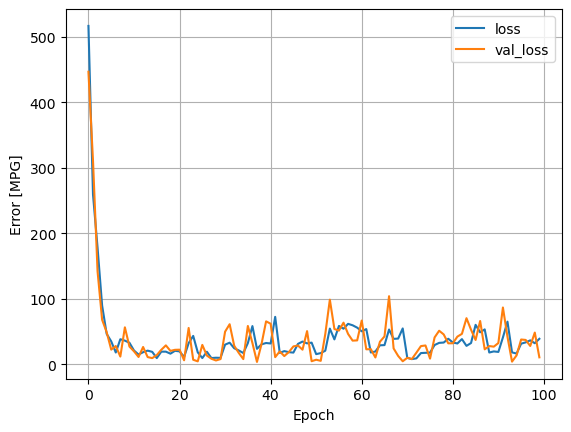

In [139]:
plot_loss(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


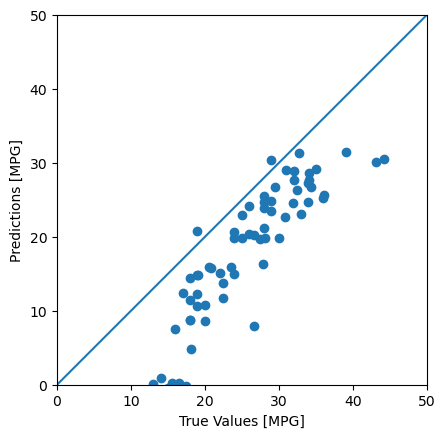

In [140]:
# Evaluate the model
test_results['all_features_model'] = model.evaluate(
    test_features, test_labels, verbose=0)
# Make predictions
test_predictions = model.predict(test_features).flatten()
# Plot predictions
def plot_predictions(predictions):
    plt.scatter(test_labels, predictions)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    _ = plt.plot([-100, 100], [-100, 100])

plot_predictions(test_predictions)

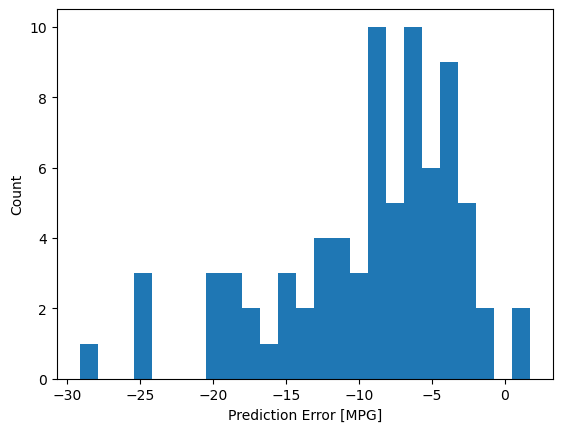

In [141]:
# Calculate the error
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")
plt.show()


In [142]:
# Deep neural network model
def build_and_compile_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(train_features.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error')
    
    return model

In [146]:
dnn_model = build_and_compile_model()
dnn_model.summary()

/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.61 s, sys: 1.18 s, total: 8.79 s
Wall time: 4.96 s


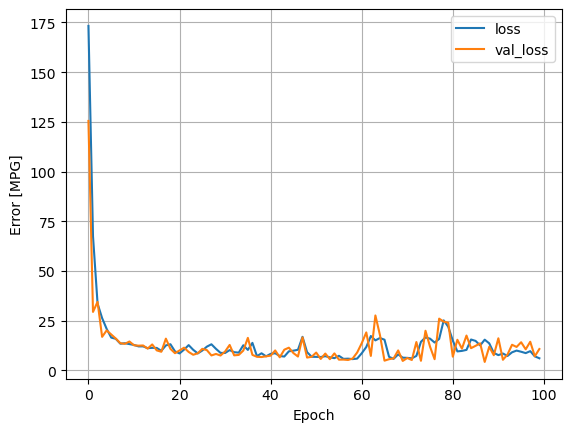

In [148]:
plot_loss(history)

In [149]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [150]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,4.004846
all_features_model,9.534787
dnn_model,10.584382
